# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [2]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [3]:
print(f"Torch: {torch.__version__}")

Torch: 1.8.1+cu102


In [4]:
# Training settings
batch_size = 50
epochs = 300
lr = 2e-4
gamma = 0.9
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
### read csv from Song-Mao


train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


#os.makedirs('../data', exist_ok=True)

In [8]:
test_df.tail()


train_dir = '/media/joshua/Milano/galaxy_zoo/train/'
test_dir = '/media/joshua/Milano/galaxy_zoo/test/'



In [9]:
train_df["GalaxyID"][0] == int(100008)

True

In [10]:
# with zipfile.ZipFile('../data/train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('../data/test.zip') as test_zip:
#     test_zip.extractall('data')

In [11]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [12]:
 
print(f"Test Data: {len(test_list)}")

Test Data: 15395


In [13]:
labels = train_df['label']


## Random Plots

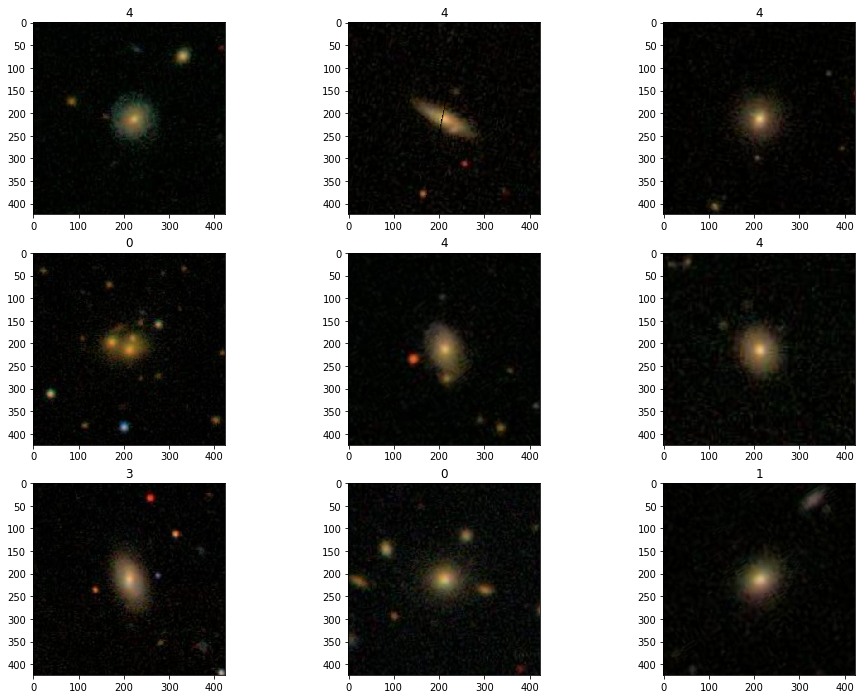

In [14]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [15]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)

In [16]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 36946
Validation Data: 9237
Test Data: 15395


## Image Augumentation

In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


## Load Datasets

In [18]:
class Galaxy_ZooDataset(Dataset):
    def __init__(self, file_list, transform=None, train=True, val=False, test=False):
        self.file_list = file_list
        self.transform = transform
        self.train = train
        self.val = val
        self.test = test
        self.train_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_train_46183_C5.csv")
        self.test_df = pd.read_csv("/media/joshua/Milano/Milano_git_work_zone/Galaxy-Zoo-Classification/class_labels_test_15395_C5.csv")


    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        ID = img_path.split("/")[-1].split(".")[0]
        ID = int(ID)
        #print("ID", ID)

        
        
        #print("image_path", img_path)
        if self.train or self.val:
            label = train_df[train_df['GalaxyID']==ID].label 
            #print(train_df[train_df['GalaxyID']==ID])
            
        else:
            label = test_df[test_df['GalaxyID']==ID].label 
        #print(label.values[0])
        label = int(label.values[0])

        return img_transformed, label


In [19]:
train_data = Galaxy_ZooDataset(train_list, transform=train_transforms, train=True, val=False, test=False)
valid_data = Galaxy_ZooDataset(valid_list, transform=test_transforms, train=False, val=True, test=False)
test_data = Galaxy_ZooDataset(test_list, transform=test_transforms, train=False, val=False, test=True)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
print(len(train_data), len(train_loader))

36946 739


In [22]:
print(len(valid_data), len(valid_loader))

9237 185


## Effecient Attention

### Linformer

In [27]:
efficient_transformer = Linformer(
    dim=256,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [28]:
model = ViT(
    dim=256,
    image_size=224,
    patch_size=32,
    num_classes=5,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [29]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [30]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            #print("label", label)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.9861 - acc: 0.6030 - val_loss : 0.9179 - val_acc: 0.6344




Epoch : 2 - loss : 0.9144 - acc: 0.6309 - val_loss : 0.8899 - val_acc: 0.6359




Epoch : 3 - loss : 0.8933 - acc: 0.6329 - val_loss : 0.8949 - val_acc: 0.6305




Epoch : 4 - loss : 0.8779 - acc: 0.6392 - val_loss : 0.8674 - val_acc: 0.6464




Epoch : 5 - loss : 0.8678 - acc: 0.6424 - val_loss : 0.8629 - val_acc: 0.6480




Epoch : 6 - loss : 0.8620 - acc: 0.6444 - val_loss : 0.8390 - val_acc: 0.6542




Epoch : 7 - loss : 0.8520 - acc: 0.6472 - val_loss : 0.8505 - val_acc: 0.6447




Epoch : 8 - loss : 0.8453 - acc: 0.6492 - val_loss : 0.8346 - val_acc: 0.6532




Epoch : 9 - loss : 0.8400 - acc: 0.6549 - val_loss : 0.8343 - val_acc: 0.6536




Epoch : 10 - loss : 0.8345 - acc: 0.6534 - val_loss : 0.8232 - val_acc: 0.6598




Epoch : 11 - loss : 0.8255 - acc: 0.6569 - val_loss : 0.8233 - val_acc: 0.6610




Epoch : 12 - loss : 0.8212 - acc: 0.6587 - val_loss : 0.8126 - val_acc: 0.6664




Epoch : 13 - loss : 0.8148 - acc: 0.6624 - val_loss : 0.8156 - val_acc: 0.6656




Epoch : 14 - loss : 0.8067 - acc: 0.6629 - val_loss : 0.7985 - val_acc: 0.6692




Epoch : 15 - loss : 0.8017 - acc: 0.6653 - val_loss : 0.8093 - val_acc: 0.6638




Epoch : 16 - loss : 0.7966 - acc: 0.6672 - val_loss : 0.7952 - val_acc: 0.6715




Epoch : 17 - loss : 0.7905 - acc: 0.6702 - val_loss : 0.7913 - val_acc: 0.6709




Epoch : 18 - loss : 0.7841 - acc: 0.6732 - val_loss : 0.7863 - val_acc: 0.6743




Epoch : 19 - loss : 0.7811 - acc: 0.6759 - val_loss : 0.7825 - val_acc: 0.6795




Epoch : 20 - loss : 0.7756 - acc: 0.6758 - val_loss : 0.7728 - val_acc: 0.6816




Epoch : 21 - loss : 0.7671 - acc: 0.6808 - val_loss : 0.7648 - val_acc: 0.6817




Epoch : 22 - loss : 0.7668 - acc: 0.6822 - val_loss : 0.7930 - val_acc: 0.6657




Epoch : 23 - loss : 0.7609 - acc: 0.6861 - val_loss : 0.7583 - val_acc: 0.6909




Epoch : 24 - loss : 0.7571 - acc: 0.6857 - val_loss : 0.7496 - val_acc: 0.6951




Epoch : 25 - loss : 0.7529 - acc: 0.6876 - val_loss : 0.7604 - val_acc: 0.6857




Epoch : 26 - loss : 0.7430 - acc: 0.6917 - val_loss : 0.7481 - val_acc: 0.6934




Epoch : 27 - loss : 0.7422 - acc: 0.6934 - val_loss : 0.7522 - val_acc: 0.6899




Epoch : 28 - loss : 0.7383 - acc: 0.6970 - val_loss : 0.7371 - val_acc: 0.6977




Epoch : 29 - loss : 0.7345 - acc: 0.6970 - val_loss : 0.7348 - val_acc: 0.6984




Epoch : 30 - loss : 0.7282 - acc: 0.6983 - val_loss : 0.7248 - val_acc: 0.7031




Epoch : 31 - loss : 0.7243 - acc: 0.7012 - val_loss : 0.7236 - val_acc: 0.7010




Epoch : 32 - loss : 0.7210 - acc: 0.7036 - val_loss : 0.7180 - val_acc: 0.7052




Epoch : 33 - loss : 0.7154 - acc: 0.7046 - val_loss : 0.7135 - val_acc: 0.7119




Epoch : 34 - loss : 0.7111 - acc: 0.7079 - val_loss : 0.7193 - val_acc: 0.7025




Epoch : 35 - loss : 0.7049 - acc: 0.7100 - val_loss : 0.6965 - val_acc: 0.7142




Epoch : 36 - loss : 0.7005 - acc: 0.7119 - val_loss : 0.7014 - val_acc: 0.7133




Epoch : 37 - loss : 0.6966 - acc: 0.7142 - val_loss : 0.7210 - val_acc: 0.6907




Epoch : 38 - loss : 0.6906 - acc: 0.7157 - val_loss : 0.6960 - val_acc: 0.7113




Epoch : 39 - loss : 0.6878 - acc: 0.7187 - val_loss : 0.6931 - val_acc: 0.7134




Epoch : 40 - loss : 0.6877 - acc: 0.7172 - val_loss : 0.6812 - val_acc: 0.7243




Epoch : 41 - loss : 0.6851 - acc: 0.7176 - val_loss : 0.6839 - val_acc: 0.7203




Epoch : 42 - loss : 0.6797 - acc: 0.7222 - val_loss : 0.6794 - val_acc: 0.7216




Epoch : 43 - loss : 0.6744 - acc: 0.7248 - val_loss : 0.6810 - val_acc: 0.7144




Epoch : 44 - loss : 0.6750 - acc: 0.7248 - val_loss : 0.6777 - val_acc: 0.7201




Epoch : 45 - loss : 0.6690 - acc: 0.7273 - val_loss : 0.6783 - val_acc: 0.7252




Epoch : 46 - loss : 0.6675 - acc: 0.7277 - val_loss : 0.6665 - val_acc: 0.7270




Epoch : 47 - loss : 0.6680 - acc: 0.7273 - val_loss : 0.6712 - val_acc: 0.7281




Epoch : 48 - loss : 0.6654 - acc: 0.7272 - val_loss : 0.6647 - val_acc: 0.7311




Epoch : 49 - loss : 0.6592 - acc: 0.7301 - val_loss : 0.6710 - val_acc: 0.7215




Epoch : 50 - loss : 0.6580 - acc: 0.7320 - val_loss : 0.6645 - val_acc: 0.7273




Epoch : 51 - loss : 0.6559 - acc: 0.7327 - val_loss : 0.6609 - val_acc: 0.7282




Epoch : 52 - loss : 0.6532 - acc: 0.7326 - val_loss : 0.6710 - val_acc: 0.7247




Epoch : 53 - loss : 0.6517 - acc: 0.7348 - val_loss : 0.6562 - val_acc: 0.7314




Epoch : 54 - loss : 0.6490 - acc: 0.7376 - val_loss : 0.6777 - val_acc: 0.7162




Epoch : 55 - loss : 0.6508 - acc: 0.7355 - val_loss : 0.6587 - val_acc: 0.7291




Epoch : 56 - loss : 0.6438 - acc: 0.7416 - val_loss : 0.6456 - val_acc: 0.7385




Epoch : 57 - loss : 0.6446 - acc: 0.7372 - val_loss : 0.6681 - val_acc: 0.7266




Epoch : 58 - loss : 0.6425 - acc: 0.7381 - val_loss : 0.6642 - val_acc: 0.7253




Epoch : 59 - loss : 0.6360 - acc: 0.7420 - val_loss : 0.6464 - val_acc: 0.7387




Epoch : 60 - loss : 0.6363 - acc: 0.7405 - val_loss : 0.6498 - val_acc: 0.7367




Epoch : 61 - loss : 0.6332 - acc: 0.7430 - val_loss : 0.6542 - val_acc: 0.7301




Epoch : 62 - loss : 0.6315 - acc: 0.7440 - val_loss : 0.6458 - val_acc: 0.7348




Epoch : 63 - loss : 0.6270 - acc: 0.7439 - val_loss : 0.6369 - val_acc: 0.7391




Epoch : 64 - loss : 0.6228 - acc: 0.7463 - val_loss : 0.6477 - val_acc: 0.7342




Epoch : 65 - loss : 0.6248 - acc: 0.7465 - val_loss : 0.6419 - val_acc: 0.7412




Epoch : 66 - loss : 0.6226 - acc: 0.7456 - val_loss : 0.6441 - val_acc: 0.7397




Epoch : 67 - loss : 0.6213 - acc: 0.7472 - val_loss : 0.6348 - val_acc: 0.7346




Epoch : 68 - loss : 0.6173 - acc: 0.7495 - val_loss : 0.6396 - val_acc: 0.7385




Epoch : 69 - loss : 0.6143 - acc: 0.7500 - val_loss : 0.6547 - val_acc: 0.7323




Epoch : 70 - loss : 0.6129 - acc: 0.7515 - val_loss : 0.6384 - val_acc: 0.7408




Epoch : 71 - loss : 0.6118 - acc: 0.7522 - val_loss : 0.6328 - val_acc: 0.7443




Epoch : 72 - loss : 0.6114 - acc: 0.7523 - val_loss : 0.6344 - val_acc: 0.7411




Epoch : 73 - loss : 0.6070 - acc: 0.7540 - val_loss : 0.6367 - val_acc: 0.7371




Epoch : 74 - loss : 0.6051 - acc: 0.7541 - val_loss : 0.6379 - val_acc: 0.7389




Epoch : 75 - loss : 0.6037 - acc: 0.7550 - val_loss : 0.6207 - val_acc: 0.7398




Epoch : 76 - loss : 0.6020 - acc: 0.7548 - val_loss : 0.6296 - val_acc: 0.7388




Epoch : 77 - loss : 0.6028 - acc: 0.7569 - val_loss : 0.6279 - val_acc: 0.7441




Epoch : 78 - loss : 0.5993 - acc: 0.7577 - val_loss : 0.6285 - val_acc: 0.7450




Epoch : 79 - loss : 0.5982 - acc: 0.7561 - val_loss : 0.6401 - val_acc: 0.7412




Epoch : 80 - loss : 0.5956 - acc: 0.7598 - val_loss : 0.6251 - val_acc: 0.7449




Epoch : 81 - loss : 0.5934 - acc: 0.7602 - val_loss : 0.6260 - val_acc: 0.7462




Epoch : 82 - loss : 0.5930 - acc: 0.7573 - val_loss : 0.6230 - val_acc: 0.7486




Epoch : 83 - loss : 0.5905 - acc: 0.7596 - val_loss : 0.6177 - val_acc: 0.7478




Epoch : 84 - loss : 0.5889 - acc: 0.7600 - val_loss : 0.6202 - val_acc: 0.7452




Epoch : 85 - loss : 0.5869 - acc: 0.7625 - val_loss : 0.6200 - val_acc: 0.7440




Epoch : 86 - loss : 0.5847 - acc: 0.7620 - val_loss : 0.6206 - val_acc: 0.7469




Epoch : 87 - loss : 0.5859 - acc: 0.7624 - val_loss : 0.6254 - val_acc: 0.7459




Epoch : 88 - loss : 0.5818 - acc: 0.7651 - val_loss : 0.6269 - val_acc: 0.7426




Epoch : 89 - loss : 0.5837 - acc: 0.7635 - val_loss : 0.6120 - val_acc: 0.7529




Epoch : 90 - loss : 0.5815 - acc: 0.7612 - val_loss : 0.6191 - val_acc: 0.7502




Epoch : 91 - loss : 0.5764 - acc: 0.7676 - val_loss : 0.6294 - val_acc: 0.7486




Epoch : 92 - loss : 0.5756 - acc: 0.7662 - val_loss : 0.6188 - val_acc: 0.7487




Epoch : 93 - loss : 0.5744 - acc: 0.7669 - val_loss : 0.6147 - val_acc: 0.7476




Epoch : 94 - loss : 0.5751 - acc: 0.7646 - val_loss : 0.6222 - val_acc: 0.7508




Epoch : 95 - loss : 0.5727 - acc: 0.7652 - val_loss : 0.6170 - val_acc: 0.7497




Epoch : 96 - loss : 0.5693 - acc: 0.7686 - val_loss : 0.6130 - val_acc: 0.7510




Epoch : 97 - loss : 0.5730 - acc: 0.7654 - val_loss : 0.6155 - val_acc: 0.7488




Epoch : 98 - loss : 0.5679 - acc: 0.7670 - val_loss : 0.6123 - val_acc: 0.7508




Epoch : 99 - loss : 0.5680 - acc: 0.7678 - val_loss : 0.6135 - val_acc: 0.7503




Epoch : 100 - loss : 0.5655 - acc: 0.7686 - val_loss : 0.6134 - val_acc: 0.7496




Epoch : 101 - loss : 0.5657 - acc: 0.7694 - val_loss : 0.6156 - val_acc: 0.7479




Epoch : 102 - loss : 0.5640 - acc: 0.7677 - val_loss : 0.6059 - val_acc: 0.7557




Epoch : 103 - loss : 0.5655 - acc: 0.7691 - val_loss : 0.6109 - val_acc: 0.7542




Epoch : 104 - loss : 0.5617 - acc: 0.7701 - val_loss : 0.6199 - val_acc: 0.7457




Epoch : 105 - loss : 0.5601 - acc: 0.7713 - val_loss : 0.6186 - val_acc: 0.7485




Epoch : 106 - loss : 0.5610 - acc: 0.7734 - val_loss : 0.6134 - val_acc: 0.7466




Epoch : 107 - loss : 0.5566 - acc: 0.7728 - val_loss : 0.6261 - val_acc: 0.7498




Epoch : 108 - loss : 0.5560 - acc: 0.7755 - val_loss : 0.6140 - val_acc: 0.7537




Epoch : 109 - loss : 0.5530 - acc: 0.7736 - val_loss : 0.6148 - val_acc: 0.7514




Epoch : 110 - loss : 0.5541 - acc: 0.7740 - val_loss : 0.6139 - val_acc: 0.7463




Epoch : 111 - loss : 0.5496 - acc: 0.7761 - val_loss : 0.6193 - val_acc: 0.7503




Epoch : 112 - loss : 0.5508 - acc: 0.7753 - val_loss : 0.6144 - val_acc: 0.7553




Epoch : 113 - loss : 0.5498 - acc: 0.7775 - val_loss : 0.6182 - val_acc: 0.7473




Epoch : 114 - loss : 0.5480 - acc: 0.7776 - val_loss : 0.6180 - val_acc: 0.7500




Epoch : 115 - loss : 0.5469 - acc: 0.7781 - val_loss : 0.6133 - val_acc: 0.7541




Epoch : 116 - loss : 0.5454 - acc: 0.7774 - val_loss : 0.6165 - val_acc: 0.7543




Epoch : 117 - loss : 0.5456 - acc: 0.7790 - val_loss : 0.6103 - val_acc: 0.7487




Epoch : 118 - loss : 0.5419 - acc: 0.7780 - val_loss : 0.6074 - val_acc: 0.7522




Epoch : 119 - loss : 0.5436 - acc: 0.7789 - val_loss : 0.6243 - val_acc: 0.7508




Epoch : 120 - loss : 0.5411 - acc: 0.7781 - val_loss : 0.6122 - val_acc: 0.7530




Epoch : 121 - loss : 0.5354 - acc: 0.7823 - val_loss : 0.6119 - val_acc: 0.7495




Epoch : 122 - loss : 0.5363 - acc: 0.7814 - val_loss : 0.6232 - val_acc: 0.7478




Epoch : 123 - loss : 0.5360 - acc: 0.7810 - val_loss : 0.6170 - val_acc: 0.7516




Epoch : 124 - loss : 0.5318 - acc: 0.7830 - val_loss : 0.6274 - val_acc: 0.7528




Epoch : 125 - loss : 0.5346 - acc: 0.7804 - val_loss : 0.6154 - val_acc: 0.7525




Epoch : 126 - loss : 0.5342 - acc: 0.7832 - val_loss : 0.6327 - val_acc: 0.7509




Epoch : 127 - loss : 0.5313 - acc: 0.7822 - val_loss : 0.6224 - val_acc: 0.7529




Epoch : 128 - loss : 0.5304 - acc: 0.7823 - val_loss : 0.6132 - val_acc: 0.7531




Epoch : 129 - loss : 0.5282 - acc: 0.7849 - val_loss : 0.6250 - val_acc: 0.7499




Epoch : 130 - loss : 0.5256 - acc: 0.7860 - val_loss : 0.6316 - val_acc: 0.7495




Epoch : 131 - loss : 0.5247 - acc: 0.7861 - val_loss : 0.6284 - val_acc: 0.7463




Epoch : 132 - loss : 0.5252 - acc: 0.7860 - val_loss : 0.6247 - val_acc: 0.7474




Epoch : 133 - loss : 0.5231 - acc: 0.7873 - val_loss : 0.6240 - val_acc: 0.7517




Epoch : 134 - loss : 0.5211 - acc: 0.7880 - val_loss : 0.6154 - val_acc: 0.7521




Epoch : 135 - loss : 0.5196 - acc: 0.7896 - val_loss : 0.6358 - val_acc: 0.7483




Epoch : 136 - loss : 0.5169 - acc: 0.7893 - val_loss : 0.6322 - val_acc: 0.7502




Epoch : 137 - loss : 0.5157 - acc: 0.7922 - val_loss : 0.6296 - val_acc: 0.7473




Epoch : 138 - loss : 0.5137 - acc: 0.7925 - val_loss : 0.6263 - val_acc: 0.7502




Epoch : 139 - loss : 0.5112 - acc: 0.7913 - val_loss : 0.6244 - val_acc: 0.7518




Epoch : 140 - loss : 0.5114 - acc: 0.7908 - val_loss : 0.6210 - val_acc: 0.7528




Epoch : 141 - loss : 0.5077 - acc: 0.7939 - val_loss : 0.6420 - val_acc: 0.7479




Epoch : 142 - loss : 0.5059 - acc: 0.7920 - val_loss : 0.6416 - val_acc: 0.7511




Epoch : 143 - loss : 0.5049 - acc: 0.7941 - val_loss : 0.6406 - val_acc: 0.7495




Epoch : 144 - loss : 0.5048 - acc: 0.7941 - val_loss : 0.6462 - val_acc: 0.7474




Epoch : 145 - loss : 0.5021 - acc: 0.7966 - val_loss : 0.6371 - val_acc: 0.7533




Epoch : 146 - loss : 0.4991 - acc: 0.7960 - val_loss : 0.6599 - val_acc: 0.7456




Epoch : 147 - loss : 0.4967 - acc: 0.7975 - val_loss : 0.6299 - val_acc: 0.7573




Epoch : 148 - loss : 0.5022 - acc: 0.7949 - val_loss : 0.6352 - val_acc: 0.7470




Epoch : 149 - loss : 0.4970 - acc: 0.7958 - val_loss : 0.6444 - val_acc: 0.7471




Epoch : 150 - loss : 0.4939 - acc: 0.8001 - val_loss : 0.6380 - val_acc: 0.7475




Epoch : 151 - loss : 0.4881 - acc: 0.8010 - val_loss : 0.6490 - val_acc: 0.7473




Epoch : 152 - loss : 0.4904 - acc: 0.7986 - val_loss : 0.6396 - val_acc: 0.7545




Epoch : 153 - loss : 0.4848 - acc: 0.8016 - val_loss : 0.6517 - val_acc: 0.7413




Epoch : 154 - loss : 0.4849 - acc: 0.8016 - val_loss : 0.6450 - val_acc: 0.7518




Epoch : 155 - loss : 0.4869 - acc: 0.8022 - val_loss : 0.6419 - val_acc: 0.7585




Epoch : 156 - loss : 0.4830 - acc: 0.8034 - val_loss : 0.6400 - val_acc: 0.7490




Epoch : 157 - loss : 0.4831 - acc: 0.8029 - val_loss : 0.6513 - val_acc: 0.7434




Epoch : 158 - loss : 0.4783 - acc: 0.8036 - val_loss : 0.6414 - val_acc: 0.7531




Epoch : 159 - loss : 0.4776 - acc: 0.8048 - val_loss : 0.6464 - val_acc: 0.7466




Epoch : 160 - loss : 0.4751 - acc: 0.8086 - val_loss : 0.6488 - val_acc: 0.7507




Epoch : 161 - loss : 0.4720 - acc: 0.8059 - val_loss : 0.6706 - val_acc: 0.7458




Epoch : 162 - loss : 0.4691 - acc: 0.8071 - val_loss : 0.6645 - val_acc: 0.7409




Epoch : 163 - loss : 0.4702 - acc: 0.8065 - val_loss : 0.6617 - val_acc: 0.7470




Epoch : 164 - loss : 0.4702 - acc: 0.8081 - val_loss : 0.6673 - val_acc: 0.7371




Epoch : 165 - loss : 0.4700 - acc: 0.8099 - val_loss : 0.6577 - val_acc: 0.7447




Epoch : 166 - loss : 0.4645 - acc: 0.8089 - val_loss : 0.6612 - val_acc: 0.7467




Epoch : 167 - loss : 0.4609 - acc: 0.8132 - val_loss : 0.6663 - val_acc: 0.7441




Epoch : 168 - loss : 0.4566 - acc: 0.8133 - val_loss : 0.6643 - val_acc: 0.7459




Epoch : 169 - loss : 0.4530 - acc: 0.8145 - val_loss : 0.6638 - val_acc: 0.7474




Epoch : 170 - loss : 0.4524 - acc: 0.8138 - val_loss : 0.6704 - val_acc: 0.7479




Epoch : 171 - loss : 0.4519 - acc: 0.8152 - val_loss : 0.6785 - val_acc: 0.7419




Epoch : 172 - loss : 0.4490 - acc: 0.8164 - val_loss : 0.6760 - val_acc: 0.7405




Epoch : 173 - loss : 0.4463 - acc: 0.8159 - val_loss : 0.6565 - val_acc: 0.7542




Epoch : 174 - loss : 0.4450 - acc: 0.8176 - val_loss : 0.6850 - val_acc: 0.7441




Epoch : 175 - loss : 0.4445 - acc: 0.8195 - val_loss : 0.6937 - val_acc: 0.7380




Epoch : 176 - loss : 0.4391 - acc: 0.8210 - val_loss : 0.7013 - val_acc: 0.7449




Epoch : 177 - loss : 0.4363 - acc: 0.8217 - val_loss : 0.7055 - val_acc: 0.7372




Epoch : 178 - loss : 0.4353 - acc: 0.8225 - val_loss : 0.7057 - val_acc: 0.7375




Epoch : 179 - loss : 0.4360 - acc: 0.8213 - val_loss : 0.6919 - val_acc: 0.7388




Epoch : 180 - loss : 0.4260 - acc: 0.8246 - val_loss : 0.7172 - val_acc: 0.7415




Epoch : 181 - loss : 0.4321 - acc: 0.8241 - val_loss : 0.7048 - val_acc: 0.7403




Epoch : 182 - loss : 0.4264 - acc: 0.8240 - val_loss : 0.6980 - val_acc: 0.7405




Epoch : 183 - loss : 0.4191 - acc: 0.8277 - val_loss : 0.7220 - val_acc: 0.7328




Epoch : 184 - loss : 0.4172 - acc: 0.8298 - val_loss : 0.7060 - val_acc: 0.7425




Epoch : 185 - loss : 0.4159 - acc: 0.8297 - val_loss : 0.7104 - val_acc: 0.7483




Epoch : 186 - loss : 0.4137 - acc: 0.8299 - val_loss : 0.6918 - val_acc: 0.7416




Epoch : 187 - loss : 0.4104 - acc: 0.8332 - val_loss : 0.7320 - val_acc: 0.7342




Epoch : 188 - loss : 0.4053 - acc: 0.8326 - val_loss : 0.7178 - val_acc: 0.7393




Epoch : 189 - loss : 0.4018 - acc: 0.8361 - val_loss : 0.7256 - val_acc: 0.7381




Epoch : 190 - loss : 0.4010 - acc: 0.8349 - val_loss : 0.7102 - val_acc: 0.7376




Epoch : 191 - loss : 0.3969 - acc: 0.8374 - val_loss : 0.7309 - val_acc: 0.7389




Epoch : 192 - loss : 0.3957 - acc: 0.8359 - val_loss : 0.7271 - val_acc: 0.7310




Epoch : 193 - loss : 0.3958 - acc: 0.8386 - val_loss : 0.7544 - val_acc: 0.7297




Epoch : 194 - loss : 0.3865 - acc: 0.8405 - val_loss : 0.7411 - val_acc: 0.7490




Epoch : 195 - loss : 0.3871 - acc: 0.8390 - val_loss : 0.7339 - val_acc: 0.7405




Epoch : 196 - loss : 0.3801 - acc: 0.8432 - val_loss : 0.7379 - val_acc: 0.7431




Epoch : 197 - loss : 0.3836 - acc: 0.8433 - val_loss : 0.7520 - val_acc: 0.7376




Epoch : 198 - loss : 0.3769 - acc: 0.8451 - val_loss : 0.7472 - val_acc: 0.7409




Epoch : 199 - loss : 0.3727 - acc: 0.8474 - val_loss : 0.7576 - val_acc: 0.7390




Epoch : 200 - loss : 0.3699 - acc: 0.8499 - val_loss : 0.7610 - val_acc: 0.7386




Epoch : 201 - loss : 0.3691 - acc: 0.8491 - val_loss : 0.7665 - val_acc: 0.7362




Epoch : 202 - loss : 0.3665 - acc: 0.8507 - val_loss : 0.8016 - val_acc: 0.7374




Epoch : 203 - loss : 0.3644 - acc: 0.8494 - val_loss : 0.7750 - val_acc: 0.7385




Epoch : 204 - loss : 0.3608 - acc: 0.8502 - val_loss : 0.7623 - val_acc: 0.7411




Epoch : 205 - loss : 0.3549 - acc: 0.8538 - val_loss : 0.7691 - val_acc: 0.7387




Epoch : 206 - loss : 0.3500 - acc: 0.8563 - val_loss : 0.7847 - val_acc: 0.7357




Epoch : 207 - loss : 0.3497 - acc: 0.8565 - val_loss : 0.8138 - val_acc: 0.7381




Epoch : 208 - loss : 0.3470 - acc: 0.8571 - val_loss : 0.8071 - val_acc: 0.7385




Epoch : 209 - loss : 0.3460 - acc: 0.8582 - val_loss : 0.8211 - val_acc: 0.7236




Epoch : 210 - loss : 0.3342 - acc: 0.8643 - val_loss : 0.8556 - val_acc: 0.7278




Epoch : 211 - loss : 0.3371 - acc: 0.8611 - val_loss : 0.8158 - val_acc: 0.7328




Epoch : 212 - loss : 0.3335 - acc: 0.8621 - val_loss : 0.8409 - val_acc: 0.7409




Epoch : 213 - loss : 0.3251 - acc: 0.8678 - val_loss : 0.8160 - val_acc: 0.7273




Epoch : 214 - loss : 0.3285 - acc: 0.8643 - val_loss : 0.8323 - val_acc: 0.7305




Epoch : 215 - loss : 0.3232 - acc: 0.8680 - val_loss : 0.8283 - val_acc: 0.7260




Epoch : 216 - loss : 0.3222 - acc: 0.8683 - val_loss : 0.8555 - val_acc: 0.7237




Epoch : 217 - loss : 0.3168 - acc: 0.8712 - val_loss : 0.8400 - val_acc: 0.7346




Epoch : 218 - loss : 0.3146 - acc: 0.8720 - val_loss : 0.8448 - val_acc: 0.7308




Epoch : 219 - loss : 0.3075 - acc: 0.8748 - val_loss : 0.8451 - val_acc: 0.7361




Epoch : 220 - loss : 0.3102 - acc: 0.8735 - val_loss : 0.8743 - val_acc: 0.7299




Epoch : 221 - loss : 0.3063 - acc: 0.8738 - val_loss : 0.8465 - val_acc: 0.7377




Epoch : 222 - loss : 0.2972 - acc: 0.8778 - val_loss : 0.8886 - val_acc: 0.7358




Epoch : 223 - loss : 0.2953 - acc: 0.8793 - val_loss : 0.8915 - val_acc: 0.7361




Epoch : 224 - loss : 0.2928 - acc: 0.8793 - val_loss : 0.8609 - val_acc: 0.7328




Epoch : 225 - loss : 0.2901 - acc: 0.8804 - val_loss : 0.8809 - val_acc: 0.7266




Epoch : 226 - loss : 0.2816 - acc: 0.8857 - val_loss : 0.9420 - val_acc: 0.7254




Epoch : 227 - loss : 0.2866 - acc: 0.8832 - val_loss : 0.9063 - val_acc: 0.7175




Epoch : 228 - loss : 0.2776 - acc: 0.8871 - val_loss : 0.8967 - val_acc: 0.7247




Epoch : 229 - loss : 0.2753 - acc: 0.8893 - val_loss : 0.9049 - val_acc: 0.7258




Epoch : 230 - loss : 0.2692 - acc: 0.8910 - val_loss : 0.9620 - val_acc: 0.7251




Epoch : 231 - loss : 0.2759 - acc: 0.8876 - val_loss : 0.9293 - val_acc: 0.7315




Epoch : 232 - loss : 0.2732 - acc: 0.8895 - val_loss : 0.9450 - val_acc: 0.7287




Epoch : 233 - loss : 0.2644 - acc: 0.8932 - val_loss : 0.9178 - val_acc: 0.7288




Epoch : 234 - loss : 0.2591 - acc: 0.8945 - val_loss : 0.9492 - val_acc: 0.7348




Epoch : 235 - loss : 0.2572 - acc: 0.8967 - val_loss : 0.9350 - val_acc: 0.7234




Epoch : 236 - loss : 0.2572 - acc: 0.8943 - val_loss : 0.9099 - val_acc: 0.7329




Epoch : 237 - loss : 0.2533 - acc: 0.8972 - val_loss : 0.9935 - val_acc: 0.7234




Epoch : 238 - loss : 0.2477 - acc: 0.8998 - val_loss : 0.9890 - val_acc: 0.7252




Epoch : 239 - loss : 0.2497 - acc: 0.8983 - val_loss : 0.9603 - val_acc: 0.7232




Epoch : 240 - loss : 0.2431 - acc: 0.9004 - val_loss : 0.9968 - val_acc: 0.7280




Epoch : 241 - loss : 0.2404 - acc: 0.9026 - val_loss : 0.9846 - val_acc: 0.7224




Epoch : 242 - loss : 0.2417 - acc: 0.9009 - val_loss : 0.9905 - val_acc: 0.7212




Epoch : 243 - loss : 0.2370 - acc: 0.9033 - val_loss : 1.0088 - val_acc: 0.7187




Epoch : 244 - loss : 0.2328 - acc: 0.9050 - val_loss : 1.0116 - val_acc: 0.7202




Epoch : 245 - loss : 0.2318 - acc: 0.9067 - val_loss : 1.0077 - val_acc: 0.7168




Epoch : 246 - loss : 0.2286 - acc: 0.9097 - val_loss : 1.0107 - val_acc: 0.7247




Epoch : 247 - loss : 0.2240 - acc: 0.9111 - val_loss : 1.0372 - val_acc: 0.7245




Epoch : 248 - loss : 0.2215 - acc: 0.9112 - val_loss : 1.0067 - val_acc: 0.7195




Epoch : 249 - loss : 0.2144 - acc: 0.9142 - val_loss : 1.0080 - val_acc: 0.7157




Epoch : 250 - loss : 0.2183 - acc: 0.9127 - val_loss : 1.0136 - val_acc: 0.7210




Epoch : 251 - loss : 0.2138 - acc: 0.9156 - val_loss : 1.0393 - val_acc: 0.7290




Epoch : 252 - loss : 0.2110 - acc: 0.9155 - val_loss : 1.0547 - val_acc: 0.7261




Epoch : 253 - loss : 0.2074 - acc: 0.9168 - val_loss : 1.0552 - val_acc: 0.7239




Epoch : 254 - loss : 0.2090 - acc: 0.9173 - val_loss : 1.0052 - val_acc: 0.7336




Epoch : 255 - loss : 0.2023 - acc: 0.9183 - val_loss : 1.0835 - val_acc: 0.7331




Epoch : 256 - loss : 0.2004 - acc: 0.9193 - val_loss : 1.0428 - val_acc: 0.7290




Epoch : 257 - loss : 0.1974 - acc: 0.9217 - val_loss : 1.0752 - val_acc: 0.7260




Epoch : 258 - loss : 0.1942 - acc: 0.9242 - val_loss : 1.0591 - val_acc: 0.7204




Epoch : 259 - loss : 0.1953 - acc: 0.9230 - val_loss : 1.0506 - val_acc: 0.7270




Epoch : 260 - loss : 0.1925 - acc: 0.9231 - val_loss : 1.1298 - val_acc: 0.7273




Epoch : 261 - loss : 0.1883 - acc: 0.9266 - val_loss : 1.1233 - val_acc: 0.7230




Epoch : 262 - loss : 0.1886 - acc: 0.9251 - val_loss : 1.0951 - val_acc: 0.7188




Epoch : 263 - loss : 0.1832 - acc: 0.9285 - val_loss : 1.1598 - val_acc: 0.7137




Epoch : 264 - loss : 0.1861 - acc: 0.9273 - val_loss : 1.0703 - val_acc: 0.7248




Epoch : 265 - loss : 0.1806 - acc: 0.9283 - val_loss : 1.1255 - val_acc: 0.7237




Epoch : 266 - loss : 0.1757 - acc: 0.9321 - val_loss : 1.1484 - val_acc: 0.7187




Epoch : 267 - loss : 0.1745 - acc: 0.9323 - val_loss : 1.0827 - val_acc: 0.7238




Epoch : 268 - loss : 0.1761 - acc: 0.9307 - val_loss : 1.1373 - val_acc: 0.7209




Epoch : 269 - loss : 0.1708 - acc: 0.9327 - val_loss : 1.1450 - val_acc: 0.7054




Epoch : 270 - loss : 0.1748 - acc: 0.9305 - val_loss : 1.1289 - val_acc: 0.7157




Epoch : 271 - loss : 0.1664 - acc: 0.9354 - val_loss : 1.1169 - val_acc: 0.7122




Epoch : 272 - loss : 0.1632 - acc: 0.9371 - val_loss : 1.1401 - val_acc: 0.7108




Epoch : 273 - loss : 0.1643 - acc: 0.9366 - val_loss : 1.1814 - val_acc: 0.7202




Epoch : 274 - loss : 0.1649 - acc: 0.9360 - val_loss : 1.1596 - val_acc: 0.7254




Epoch : 275 - loss : 0.1617 - acc: 0.9363 - val_loss : 1.2063 - val_acc: 0.7221




Epoch : 276 - loss : 0.1555 - acc: 0.9387 - val_loss : 1.2345 - val_acc: 0.7130




Epoch : 277 - loss : 0.1544 - acc: 0.9393 - val_loss : 1.1404 - val_acc: 0.7230




Epoch : 278 - loss : 0.1536 - acc: 0.9393 - val_loss : 1.1944 - val_acc: 0.7195




Epoch : 279 - loss : 0.1516 - acc: 0.9417 - val_loss : 1.1671 - val_acc: 0.7193




Epoch : 280 - loss : 0.1521 - acc: 0.9400 - val_loss : 1.2036 - val_acc: 0.7222




Epoch : 281 - loss : 0.1503 - acc: 0.9417 - val_loss : 1.2219 - val_acc: 0.7144




Epoch : 282 - loss : 0.1474 - acc: 0.9432 - val_loss : 1.1944 - val_acc: 0.7159




Epoch : 283 - loss : 0.1455 - acc: 0.9440 - val_loss : 1.2140 - val_acc: 0.7285




Epoch : 284 - loss : 0.1440 - acc: 0.9448 - val_loss : 1.2021 - val_acc: 0.7168




Epoch : 285 - loss : 0.1462 - acc: 0.9433 - val_loss : 1.1790 - val_acc: 0.7211




Epoch : 286 - loss : 0.1407 - acc: 0.9459 - val_loss : 1.2052 - val_acc: 0.7177




Epoch : 287 - loss : 0.1420 - acc: 0.9448 - val_loss : 1.2455 - val_acc: 0.7245




Epoch : 288 - loss : 0.1390 - acc: 0.9469 - val_loss : 1.2550 - val_acc: 0.7178




Epoch : 289 - loss : 0.1362 - acc: 0.9477 - val_loss : 1.2280 - val_acc: 0.7154




Epoch : 290 - loss : 0.1378 - acc: 0.9472 - val_loss : 1.2607 - val_acc: 0.7155




Epoch : 291 - loss : 0.1335 - acc: 0.9510 - val_loss : 1.2384 - val_acc: 0.7133




Epoch : 292 - loss : 0.1350 - acc: 0.9490 - val_loss : 1.1959 - val_acc: 0.7235




Epoch : 293 - loss : 0.1293 - acc: 0.9510 - val_loss : 1.2627 - val_acc: 0.7210




Epoch : 294 - loss : 0.1290 - acc: 0.9511 - val_loss : 1.2314 - val_acc: 0.7201




Epoch : 295 - loss : 0.1276 - acc: 0.9504 - val_loss : 1.2545 - val_acc: 0.7244




Epoch : 296 - loss : 0.1279 - acc: 0.9511 - val_loss : 1.3075 - val_acc: 0.7174




Epoch : 297 - loss : 0.1272 - acc: 0.9512 - val_loss : 1.3051 - val_acc: 0.7153




Epoch : 298 - loss : 0.1193 - acc: 0.9557 - val_loss : 1.2842 - val_acc: 0.7252




Epoch : 299 - loss : 0.1219 - acc: 0.9542 - val_loss : 1.2430 - val_acc: 0.7132




Epoch : 300 - loss : 0.1214 - acc: 0.9546 - val_loss : 1.3085 - val_acc: 0.7107



In [31]:
val_output = model(data)
val_output




tensor([[ -7.9901,   5.8650, -13.5936,  -6.8872,   4.5055],
        [ -8.4078,   5.2526, -11.3351,   6.3003,  -1.8569],
        [ -8.4034,  -1.5270, -13.2742,  -8.3835,  10.5416],
        [ -5.6884,   1.8171, -15.0801,  -2.0374,   4.3554],
        [ -2.5516,  -2.7622,  -6.9976,  -5.5105,   6.9767],
        [-16.0571,   4.9972,  -8.8575,  -7.4576,   9.2759],
        [ -6.5192,   6.8301, -13.9929,  -8.4209,   3.6159],
        [ -4.5427,   0.4087, -14.0111,  -9.3302,   7.2728],
        [  4.8538,  -8.6635, -13.8963,  -7.9990,   7.6127],
        [  3.6251,  -7.3987,  -7.8502,  -9.9623,   8.5475],
        [  4.1400,  -8.7583, -11.4783,  -5.7400,   6.2204],
        [ -7.0201,   8.4524, -13.3282,   3.3209,  -3.2070],
        [  2.9009,  -8.0635, -14.3164,  -8.2628,   7.3634],
        [  5.4967,  -8.8472, -12.0657,  -6.7395,   6.0232],
        [ -5.5949,   4.5240, -14.8386,  -6.0562,   3.4585],
        [  1.9769,  -3.9636, -12.8108,  -5.2892,   4.4628],
        [-10.8721,   9.5011,  -6.0505, -

In [32]:
test_data[0][1]

1

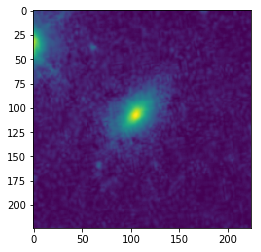

0
prediction tensor([4], device='cuda:0')


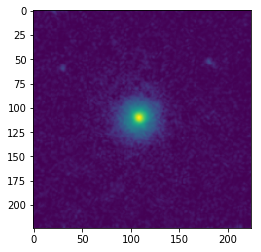

4
prediction tensor([4], device='cuda:0')


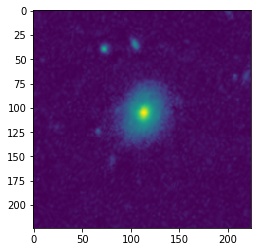

4
prediction tensor([4], device='cuda:0')


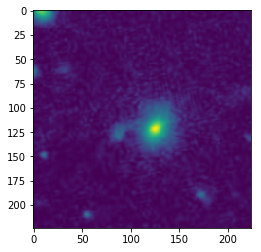

0
prediction tensor([0], device='cuda:0')


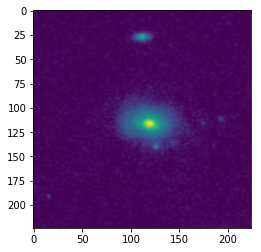

4
prediction tensor([4], device='cuda:0')


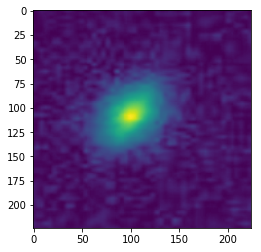

4
prediction tensor([4], device='cuda:0')


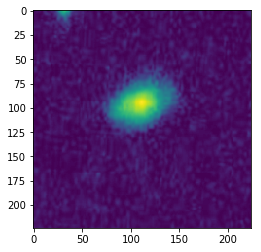

4
prediction tensor([4], device='cuda:0')


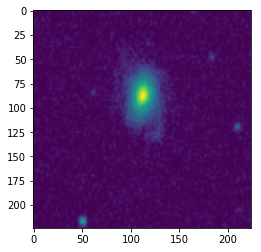

1
prediction tensor([4], device='cuda:0')


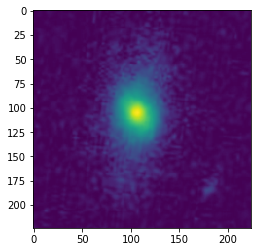

4
prediction tensor([0], device='cuda:0')


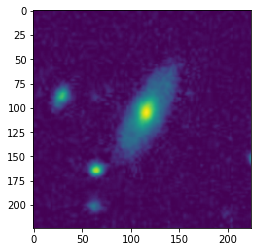

4
prediction tensor([1], device='cuda:0')


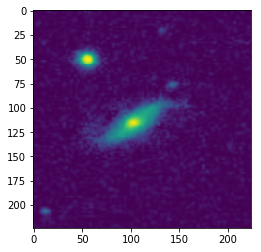

1
prediction tensor([4], device='cuda:0')


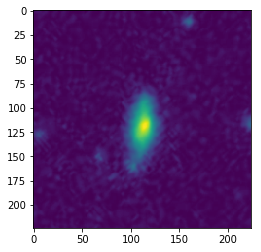

4
prediction tensor([1], device='cuda:0')


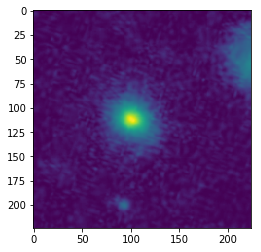

4
prediction tensor([4], device='cuda:0')


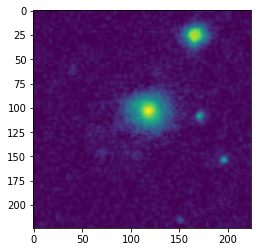

4
prediction tensor([4], device='cuda:0')


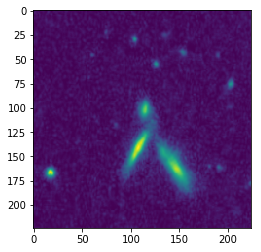

1
prediction tensor([1], device='cuda:0')


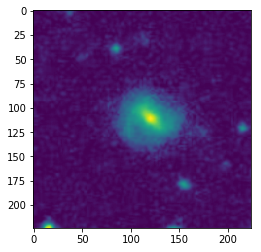

1
prediction tensor([1], device='cuda:0')


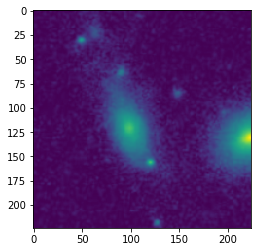

3
prediction tensor([3], device='cuda:0')


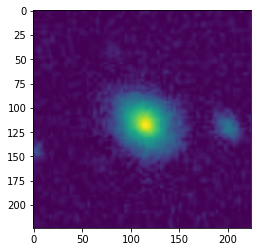

4
prediction tensor([4], device='cuda:0')


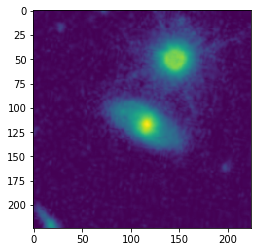

1
prediction tensor([1], device='cuda:0')


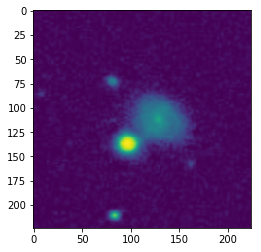

1
prediction tensor([1], device='cuda:0')


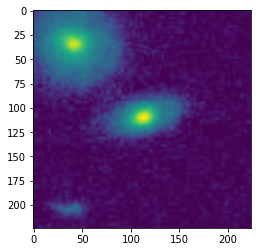

1
prediction tensor([4], device='cuda:0')


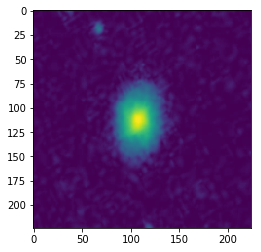

4
prediction tensor([4], device='cuda:0')


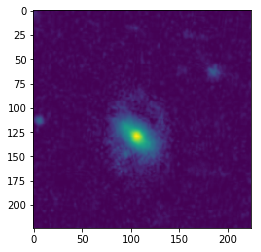

4
prediction tensor([1], device='cuda:0')


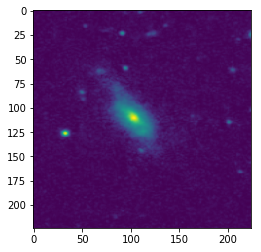

1
prediction tensor([1], device='cuda:0')


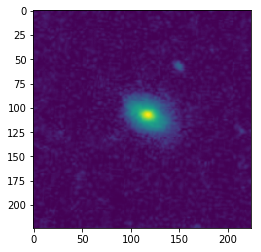

4
prediction tensor([4], device='cuda:0')


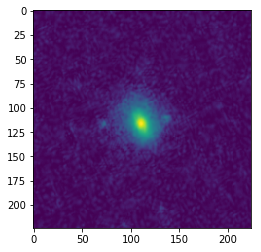

4
prediction tensor([1], device='cuda:0')


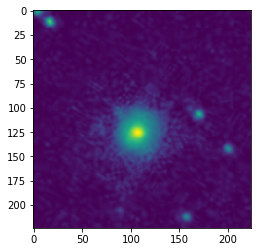

4
prediction tensor([4], device='cuda:0')


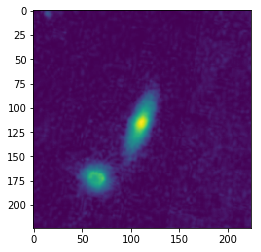

4
prediction tensor([4], device='cuda:0')


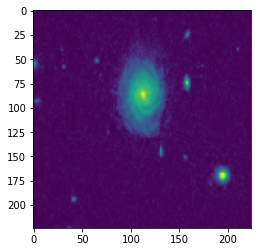

1
prediction tensor([1], device='cuda:0')


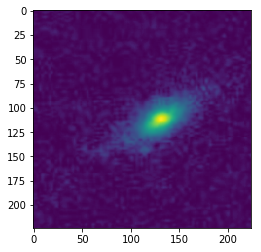

4
prediction tensor([4], device='cuda:0')


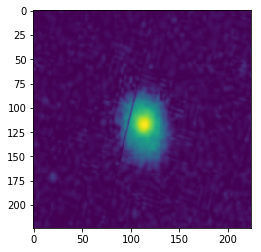

0
prediction tensor([4], device='cuda:0')


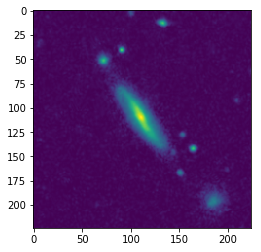

4
prediction tensor([4], device='cuda:0')


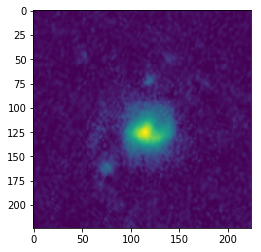

1
prediction tensor([1], device='cuda:0')


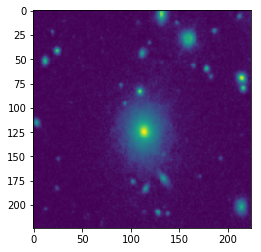

0
prediction tensor([4], device='cuda:0')


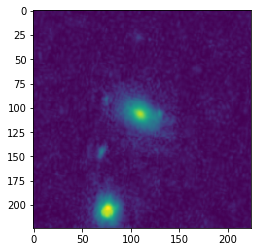

4
prediction tensor([1], device='cuda:0')


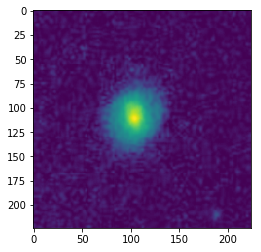

4
prediction tensor([4], device='cuda:0')


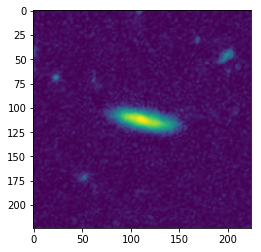

4
prediction tensor([4], device='cuda:0')


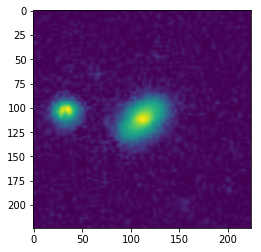

4
prediction tensor([4], device='cuda:0')


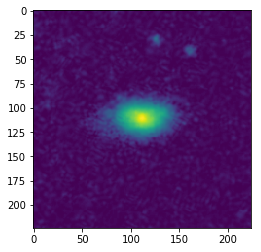

4
prediction tensor([1], device='cuda:0')


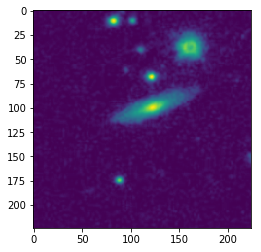

4
prediction tensor([4], device='cuda:0')


In [33]:
for idx in range(40):
    #img = Image.open(data[idx].cpu())
#     ax.set_title(labels[idx])
#     ax.imshow(test_data[idx])
    plt.imshow(valid_data[idx][0][0])
    #plt.title("label:", test_data[idx][1])
    plt.show()
    print(valid_data[idx][1])
    prediction_latent = model(valid_data[idx][0].unsqueeze(0).cuda())
    
    print("prediction", prediction_latent.argmax(dim=1))
    #print(valid_data[idx][0].shape)